Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import rdflib
from rdflib import Graph, Literal, Namespace, RDF, URIRef, OWL
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
from rdflib.namespace import DC, FOAF

from owlready2 import *
from owlready2 import get_ontology

from sklearn.model_selection import train_test_split

import networkx as nx
import networkx.algorithms.community as nx_comm

random.seed(10)

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


Loading the original data

In [8]:
data = pd.read_excel('opioid_data_merged_min.xlsx')

In [9]:
data

,WorldwideUniqueCaseIdentification,sex,Outcome,ATCode,PTCode,Frequency,age_group,weight_group,is_sideeffect
0,NL-002147023-NVSC2020NL143475,female,Recovered with sequelae,N02AX02,10012218,0.1,"(64.0, 90.0]",overweight,True
1,NL-002147023-NVSC2020NL143475,female,Recovered with sequelae,N02AX02,10075611,0.0,"(64.0, 90.0]",overweight,False
2,NL-002147023-NVSC2020NL223553,female,Recovered,N02AX02,10076493,0.0,"(64.0, 90.0]",overweight,False
3,NL-002147023-NVSC2020NL223553,female,Recovered,N02AX02,10009839,0.0,"(64.0, 90.0]",overweight,False
4,NL-002147023-NVSC2020NL223553,female,Recovered,N02AX02,10009839,0.0,"(64.0, 90.0]",overweight,False
...,...,...,...,...,...,...,...,...,...
6192,NL-TEVA-719924ROM,male,Recovered,N02AA05,10037660,0.0,"(64.0, 90.0]",normal,False
6193,NL-TEVA-719924ROM,male,Recovered,N02AA05,10062352,0.0,"(64.0, 90.0]",normal,False
6194,NL-TEVA-719924ROM,male,Recovered,N02AA05,10006002,0.0,"(64.0, 90.0]",normal,False
6195,NL-TEVA-719924ROM,male,Recovered,N02AA05,10046571,0.0,"(64.0, 90.0]",normal,False


In [10]:
train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

In [11]:
data['WorldwideUniqueCaseIdentification'] = data.WorldwideUniqueCaseIdentification.astype(str)
data['age_group'] = data.age_group.astype(str)
data['PTCode'] = data.PTCode.astype(str)

In [12]:
triples = []
for _, row in train.iterrows():
        
    # Weight group info
    weight_group = (row['WorldwideUniqueCaseIdentification'], "hasWeightGroup", row['weight_group'])

    # Age group info
    age_group = (row['WorldwideUniqueCaseIdentification'], "hasAgeGroup", row['age_group'])

    # Gender info
    sex = (row['WorldwideUniqueCaseIdentification'], "hasGender", row['sex'])

    #Outcome
    outcome = (row['WorldwideUniqueCaseIdentification'], "hasOutcome", row['Outcome'])

    #Symptom
    symptom = (row['WorldwideUniqueCaseIdentification'], "hasSymptom", row['PTCode'])

    #Drug
    drug = (row['WorldwideUniqueCaseIdentification'], "isGivenDrug", row['ATCode'])

    #Frequency
    frequency = (row['PTCode'], "hasFrequency", row['Frequency'])    
    
    #Side effect
    if row['is_sideeffect'] == True:
        side_effect = (row['WorldwideUniqueCaseIdentification'], "hasSideEffect", row['PTCode'])
    else:
        side_effect = (row['WorldwideUniqueCaseIdentification'], "hasSideEffect", "None")

    triples.extend((weight_group, age_group, sex, outcome, symptom, drug, frequency, side_effect))

In [15]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df = triples_df.drop_duplicates()
triples_df[(triples_df.subject=="NL-TEVA-719924ROM")]

,subject,predicate,object
1240,NL-TEVA-719924ROM,hasWeightGroup,normal
1241,NL-TEVA-719924ROM,hasAgeGroup,"(64.0, 90.0]"
1242,NL-TEVA-719924ROM,hasGender,male
1243,NL-TEVA-719924ROM,hasOutcome,Recovered
1244,NL-TEVA-719924ROM,hasSymptom,10046571
1245,NL-TEVA-719924ROM,isGivenDrug,N02AA05
1247,NL-TEVA-719924ROM,hasSideEffect,None
5340,NL-TEVA-719924ROM,hasSymptom,10006002
8628,NL-TEVA-719924ROM,hasSymptom,10062352
12548,NL-TEVA-719924ROM,hasSymptom,10047700


In [35]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=7930)

In [36]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (31726, 3)
Test set size:  (7930, 3)


In [37]:
from ampligraph.latent_features.models import ScoringBasedEmbeddingModel as model_embedding
    
# Initialize a ComplEx neural embedding model: the embedding size is k,
# eta specifies the number of corruptions to generate per each positive,
# scoring_type determines the scoring function of the embedding model.
model = ScoringBasedEmbeddingModel(k=150,
                                   eta=10,
                                   scoring_type='ComplEx')

In [38]:
import tensorflow as tf

from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

# Optimizer, loss and regularizer definition
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = get_loss('pairwise', {'margin': 0.5})
regularizer = get_regularizer('LP', {'p': 2, 'lambda': 1e-5})

# Compilation of the model
model.compile(loss=loss,
              optimizer='adam',
              entity_relation_regularizer=regularizer,
              entity_relation_initializer='glorot_uniform')

In [39]:
# Fit the model on training and validation set
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 10), # use 1/10 of the training set as batch size
          epochs=100,                    # Number of training epochs
          verbose=True                  # Enable stdout messages
          )

Epoch 1/100
12/12 [==============================] - 5s 452ms/step - loss: 14396.8057
Epoch 2/100
12/12 [==============================] - 3s 273ms/step - loss: 14341.7666
Epoch 3/100
12/12 [==============================] - 3s 254ms/step - loss: 14254.0977
Epoch 4/100
12/12 [==============================] - 3s 252ms/step - loss: 14103.8096
Epoch 5/100
12/12 [==============================] - 3s 258ms/step - loss: 13849.7803
Epoch 6/100
12/12 [==============================] - 3s 267ms/step - loss: 13436.0557
Epoch 7/100
12/12 [==============================] - 3s 265ms/step - loss: 12802.7998
Epoch 8/100
12/12 [==============================] - 3s 257ms/step - loss: 11993.0459
Epoch 9/100
12/12 [==============================] - 3s 264ms/step - loss: 11167.1494
Epoch 10/100
12/12 [==============================] - 3s 261ms/step - loss: 10407.8125
Epoch 11/100
12/12 [==============================] - 3s 259ms/step - loss: 9726.7031
Epoch 12/100
12/12 [==============================] -

In [40]:
filter = {'test': np.concatenate([X_train, X_test])}

In [41]:
ranks = model.evaluate(X_test,
                       use_filter=filter,
                       corrupt_side='s,o',
                       verbose=True)

249/249 [==============================] - 39s 157ms/step


In [42]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.63
MR: 144.48
Hits@10: 0.67
Hits@3: 0.64
Hits@1: 0.61


In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
%matplotlib inline

In [45]:
patients = train.WorldwideUniqueCaseIdentification.unique()
patient_embeddings = dict(zip(patients, model.get_embeddings(patients)))

In [46]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in patient_embeddings.values()]))

In [47]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(patients, model, clustering_algorithm, mode='e')

In [48]:
plot_df = pd.DataFrame({"patients": patients, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [54]:
# Plot 2D embeddings
def plot_clusters(hue):
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df,
                         x="embedding1", y="embedding2", hue=hue)
    texts = []
    adjust_text(texts)

IndexError: list index out of range

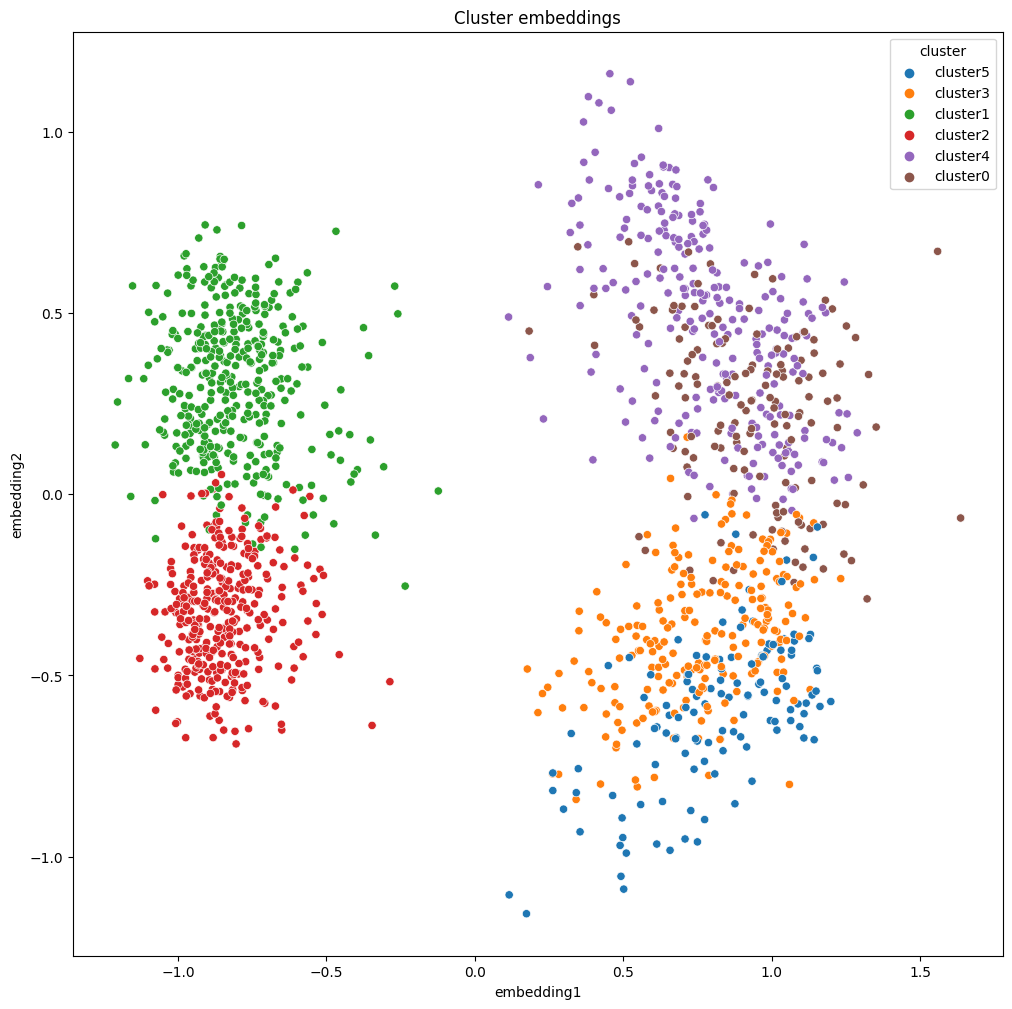

In [55]:
plot_clusters("cluster")